In [38]:
import os
import sys
import time
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import linregress
from sklearn.neighbors import KernelDensity
from datetime import date, datetime, timedelta

In [39]:
## Read data

# Variables - change these as needed
job_id = '02Feb2021'
week_minus_one = '24-Jan-2021'

# Fixed variables
dc_location_allowed = {'GB40','GB47','GB73'}
test_weeks = 8
horizon_weeks = 12
data_path = '/Users/sandeepdhankhar/OneDrive - Aera Technology/8 Project Mars/Data/'

dc_forecast = pd.read_csv(os.path.join(data_path,job_id,'input','dc_forecast.csv'), dtype = {'dfu':str,'location':str})
dc_actuals = pd.read_csv(os.path.join(data_path,job_id,'input','dc_actuals.csv'), dtype = {'dfu':str,'location':str})
prodn_actuals = pd.read_csv(os.path.join(data_path,job_id,'input','production_actuals.csv'), dtype = {'dfu':str,'location':str})    


## Pre-processing

In [40]:
## Functions
def get_year_week(dateSeries):
    yearSeries = dateSeries.apply(lambda x: x.strftime("%Y")).astype(str)
    weekSeries = dateSeries.apply(lambda x: x.strftime("%U")).astype(str)  #week starting Sunday - same as Mars
    yearWeek = yearSeries + weekSeries
    return yearWeek.astype(int)

def get_missing_snapshots(single_grain,dfu_name,location_name,suffix):
    # Snapshots present
    snapshotsPresent = set(single_grain['Week_Start_Date'])
    numOfSnapshots = len(snapshotsPresent)
    firstSnapshotDate = min(snapshotsPresent)
    lastSnapshotDate = max(snapshotsPresent)
    # Find missing snapshots date
    all_snapshots = set(pd.date_range(start = firstSnapshotDate, end = lastSnapshotDate, freq = 'W'))
    missingSnapshots = all_snapshots - snapshotsPresent
    missingSnapshots = [x.strftime('%Y-%m-%d') for x in missingSnapshots]
    # Consolidate
    summary = {'dfu':dfu_name,'location':location_name,'NumOfSnapshot'+suffix:numOfSnapshots,
               'FirstSnapshot'+suffix:firstSnapshotDate.strftime('%Y-%m-%d'),
               'LastSnapshot'+suffix:lastSnapshotDate.strftime('%Y-%m-%d'),
               'MissingSnapshot'+suffix:missingSnapshots,
               'NumberOfSnapshotsMissing'+suffix:len(missingSnapshots)
               }
    return summary

def get_snapshot_summary(data,group,suffix):
    grain_summary = []
    grain_groups = data.groupby(group)
    for name,group in grain_groups:
        grain_summary.append(get_missing_snapshots(group,name[0],name[1],suffix))
    data_summary = pd.DataFrame(grain_summary)    
    #data_summary = data_summary[data_summary['NumberOfSnapshotsMissing'] != 0]
    return data_summary

def insert_missing_time_periods_prodn(prodn):
    # looping over each grain
    grain_groups = prodn.groupby(['dfu','location','line'])
    grain_complete = []
    for name,singleGrain in grain_groups:
        # Re-index - add all time periods between start and end date
        singleGrain = singleGrain.set_index('Week_Start_Date')
        idx = pd.date_range(start = min(singleGrain.index),end = max(singleGrain.index),freq='W')
        singleGrain = singleGrain.reindex(list(idx))
        # fill na
        singleGrain[['dfu','location','line']] = singleGrain[['dfu','location','line']].fillna(method='ffill')
        singleGrain[['actual_production_in_ea','scheduled_production_in_ea']] = singleGrain[['actual_production_in_ea','scheduled_production_in_ea']].fillna(method='ffill')
        singleGrain[['csl','ats']] = singleGrain[['csl','ats']].fillna(method='ffill')
        grain_complete.append(singleGrain)
    # re-arrange cols
    prodn_complete = pd.concat(grain_complete).reset_index()
    return prodn_complete[['dfu','location','line','Week_Start_Date','actual_production_in_ea','scheduled_production_in_ea','csl','ats']]

def mad_outlier_treatment(data,col):
    d = data.copy()
    # 2MAD method
    d['ShiftedQty'] = d[col].shift(1)
    d['RollingMedian'] = d['ShiftedQty'].transform(lambda x: x.rolling(6, 1).median())
    d['AbsDeviation'] = abs(d['RollingMedian'] - d[col])
    d['MAD'] = d['AbsDeviation'].median()
    d['OutlierFlag_2MAD'] = [1 if dev > 2*mad else 0 for dev,mad in zip(d['AbsDeviation'],d['MAD'])]
    d[col+'_MAD'] = [z if x==1 else y for x,y,z in zip(d['OutlierFlag_2MAD'],d[col],d['RollingMedian'])]
    d = d.drop(['ShiftedQty','RollingMedian','AbsDeviation','MAD','OutlierFlag_2MAD'],axis=1) 
    return d

def iqr_outlier_treatment(data,col):
    d = data.copy()
    q1,q3 = np.percentile(d[col],[25,75])
    IQR = q3-q1
    lower_bound = q1 - (IQR*1.5)
    upper_bound = q3 + (IQR*1.5)
    d[col+'_IQR'] = d[col]
    d[col+'_IQR'] = [lower_bound if x < lower_bound else x for x in d[col]]
    d[col+'_IQR'] = [upper_bound if x > upper_bound else x for x in d[col]]
    return d

def get_ats_csl_correlation(data,ats_col):
    ats = data[ats_col]
    csl = data['csl']
    csl = csl[~ats.isin([np.nan, np.inf, -np.inf])] # Remove unwanted values
    ats = ats[~ats.isin([np.nan, np.inf, -np.inf])] # Remove unwanted values
    out = linregress(ats,csl)
    return pd.DataFrame({'Correlation':[out.rvalue],'P-Value':[out.pvalue],'NumOfPoints':[len(ats)],'Coefficient':[out.slope]})

def recalculate_ats(row):
    if (row['actual_production_in_ea'] == 0) & (row['scheduled_production_in_ea'] == 0):
        return 100
    elif row['scheduled_production_in_ea'] == 0:
        return 0
    else:
        return row['actual_production_in_ea']*100/row['scheduled_production_in_ea']
    
def cap_ats(ats):
    if ats > 120:
        return 120
    elif ats < 80:
        return 80
    else:
        return ats
    
def get_max_density_outcome(series):
    try:
        #sns.distplot(data, hist=False)
        #plt.show()
        X = series.to_numpy().reshape(-1,1)
        kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X)
        X_plot = np.linspace(-100, 300, 1000)[:, np.newaxis]    
        log_dens = np.exp(kde.score_samples(X_plot))
        max_density_val = X_plot[np.argmax(log_dens),0]
    except:
        max_density_val = 0
    return max_density_val

def train_linear_model(data,y,x):
    slope, intercept, r_value, p_value, std_err = linregress(data[x], data[y])
    return pd.DataFrame({'slope':[slope], 'intercept':[intercept]})

In [41]:
# Column rename
dc_forecast.rename(columns = {'forecast_week':'Week_Start_Date'}, inplace = True)
dc_actuals.rename(columns = {'week':'Week_Start_Date'}, inplace = True)
prodn_actuals.rename(columns = {'date':'Week_Start_Date'}, inplace = True)

# Convert to datetime
dc_forecast['Week_Start_Date'] = pd.to_datetime(dc_forecast['Week_Start_Date'],format='%Y-%m-%d')
dc_actuals['Week_Start_Date'] = pd.to_datetime(dc_actuals['Week_Start_Date'],format='%Y-%m-%d')
prodn_actuals['Week_Start_Date'] = pd.to_datetime(prodn_actuals['Week_Start_Date'],format='%Y-%m-%d')

# Filter unknown data
dc_forecast = dc_forecast[~((dc_forecast['dfu'] == "Not Set") | (dc_forecast['location'] == "not_available"))]
dc_actuals = dc_actuals[~((dc_actuals['dfu'] == "Not Set") | (dc_actuals['location'] == "not_available"))]
prodn_actuals = prodn_actuals[~((prodn_actuals['dfu'] == "Not Set") | (prodn_actuals['location'] == "not_available") | (prodn_actuals['line'] == "Not Set"))]
dc_actuals = dc_actuals[dc_actuals['location'].isin(dc_location_allowed)]

# Keep historical data
week_minus_one = datetime.strptime(week_minus_one,'%d-%b-%Y')
dc_forecast = dc_forecast[dc_forecast['Week_Start_Date'] <= week_minus_one]
dc_actuals = dc_actuals[dc_actuals['Week_Start_Date'] <= week_minus_one]
prodn_actuals = prodn_actuals[prodn_actuals['Week_Start_Date'] <= week_minus_one]

# Get top DFU's - 90% portfolio share in past 1 year
date_now = datetime.now()
date_year_ago = date_now - timedelta(days = 365)
cutOff = 90
lastOneYearActual = dc_actuals.loc[dc_actuals['Week_Start_Date'] >= date_year_ago]
aggLastOneYear = lastOneYearActual.groupby(['dfu']).agg(PercentageShare=('actuals',lambda x: round(x.sum()*100/sum(lastOneYearActual['actuals']),2))).reset_index()
aggLastOneYear = aggLastOneYear.sort_values(by=['PercentageShare'], ascending=False).reset_index(drop=True)
aggLastOneYear['CumulativeShare'] = aggLastOneYear['PercentageShare'].cumsum()    
top_dfu = list(aggLastOneYear['dfu'][aggLastOneYear['CumulativeShare'] <=cutOff])

# Keep top DFU's
dc_forecast  = dc_forecast[dc_forecast['dfu'].isin(top_dfu)]
dc_actuals  = dc_actuals[dc_actuals['dfu'].isin(top_dfu)]
prodn_actuals  = prodn_actuals[prodn_actuals['dfu'].isin(top_dfu)]

In [42]:
# Holdout and test period
last_date = week_minus_one
holdout_date = last_date - timedelta(days=7*test_weeks) #8 weeks test data
horizon_date = last_date + timedelta(days=7*horizon_weeks) #12 weeks in future
date_series = pd.Series([holdout_date,last_date,horizon_date])
cortex_ip = pd.DataFrame({'Type': ['HoldOut','LastDate','HorizonDate'],
                               'YearWeek': list(get_year_week(date_series)),
                               'Date':[holdout_date,last_date,horizon_date]})
cortex_ip

Type  YearWeek       Date
0      HoldOut    202048 2020-11-29
1     LastDate    202104 2021-01-24
2  HorizonDate    202116 2021-04-18

In [43]:
# Missing snapshot summary
prodn_summary = get_snapshot_summary(prodn_actuals,['dfu','location'],'_prodn')
prodn_summary = prodn_summary[['dfu','location','FirstSnapshot_prodn','LastSnapshot_prodn','NumberOfSnapshotsMissing_prodn']]
prodn_summary.columns = ['DFU','Location','First_Snapshot_Production','Last_Snapshot_Production','Num_of_Missing_Snapshots_Production']
prodn_summary = prodn_summary.sort_values('Num_of_Missing_Snapshots_Production',ascending = False)
prodn_summary.head()

DFU Location First_Snapshot_Production Last_Snapshot_Production  \
0   104383     FR08                2019-09-08               2021-01-24   
57  361874     FR08                2019-09-08               2021-01-24   
83  393104     PL01                2019-09-08               2021-01-24   
82  393080     PL01                2019-09-08               2021-01-03   
81  392086     RU09                2019-09-08               2021-01-24   

    Num_of_Missing_Snapshots_Production  
0                                     0  
57                                    0  
83                                    0  
82                                    0  
81                                    0

In [44]:
## Forward fill ATS when scheduled and actual production is 0
prodn_actuals_complete = insert_missing_time_periods_prodn(prodn_actuals)
# Remove data before 1st Jan 2020 => ats,csl missing in most of the grains
prodn_actuals_complete = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] >= datetime(2020, 1, 1)]

def make_ats_nan(row,col):
    if (row['actual_production_in_ea'] == 0) & (row['scheduled_production_in_ea']==0):
        return np.nan
    else:
        return row[col]

def apply_ats_nan_per_group(group):
    group['ats'] = group.apply(make_ats_nan,col='ats',axis=1)
    group['ffill_flag'] = group['ats'].apply(lambda x: 1 if math.isnan(x) else 0)
    group['ats'] = group['ats'].fillna(method='ffill')
    actual_prodn = group.apply(make_ats_nan,col='actual_production_in_ea',axis=1).fillna(method='ffill')
    sched_prodn = group.apply(make_ats_nan,col='scheduled_production_in_ea',axis=1).fillna(method='ffill')
    group['actual_production_in_ea'] = actual_prodn
    group['scheduled_production_in_ea'] = sched_prodn
    return group

prodn_actuals_complete = prodn_actuals_complete.groupby(['dfu','location']).apply(apply_ats_nan_per_group).reset_index(drop=True)

# Recalculate ATS
prodn_actuals_complete['ats'] = prodn_actuals_complete.apply(recalculate_ats,axis=1)
prodn_actuals_complete = prodn_actuals_complete.fillna(1)


In [45]:
# Calculate lag1 and lag2
prodn_actuals_complete['ats_lag1'] = prodn_actuals_complete.groupby(['dfu','location'])['ats'].shift(1)
prodn_actuals_complete['ats_lag2'] = prodn_actuals_complete.groupby(['dfu','location'])['ats'].shift(2)
prodn_actuals_complete.head()


dfu location        line Week_Start_Date  actual_production_in_ea  \
0  104383     FR08  HAG CRISPY      2020-01-05                  13850.0   
1  104383     FR08  HAG CRISPY      2020-01-12                  34239.0   
2  104383     FR08  HAG CRISPY      2020-01-19                  30611.0   
3  104383     FR08  HAG CRISPY      2020-01-26                  30156.0   
4  104383     FR08  HAG CRISPY      2020-02-02                  27245.0   

   scheduled_production_in_ea    csl         ats  ffill_flag    ats_lag1  \
0                     13000.0   0.00  106.538462           0         NaN   
1                     33899.0  17.20  101.002979           0  106.538462   
2                     23800.0  63.57  128.617647           0  101.002979   
3                     40161.0   5.04   75.087772           0  128.617647   
4                     18116.0  30.07  150.391919           0   75.087772   

     ats_lag2  
0         NaN  
1         NaN  
2  106.538462  
3  101.002979  
4  128.617647

## DFU Level Analysis

Number of grains considered - 113


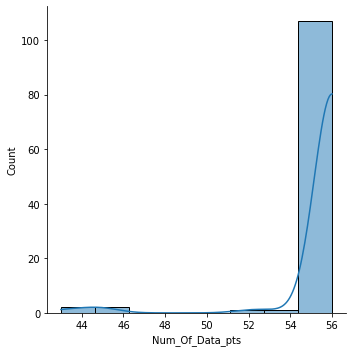

In [46]:
# Disribution of data points
num_of_data_pts_per_grain = prodn_actuals_complete.groupby(['dfu','location']).agg(Num_Of_Data_pts = ('dfu','count'))
print('Number of grains considered - {}'.format(len(num_of_data_pts_per_grain)))
sns.displot(num_of_data_pts_per_grain, x="Num_Of_Data_pts",kde=True)

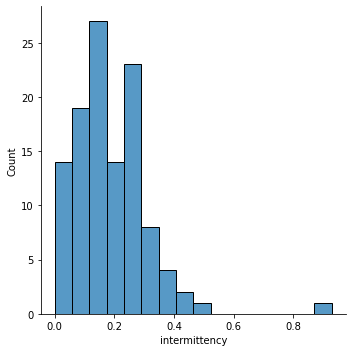

In [47]:
# Intermittency in ATS
prodn_actuals_complete['ats_is_zero'] = prodn_actuals_complete['ats'].apply(lambda x: 1 if x==0 else 0)
intermittency = prodn_actuals_complete.groupby(['dfu','location']).agg(intermittency = ('ats_is_zero','mean'))
sns.displot(intermittency, x="intermittency")

In [48]:
#intermittency.to_csv(os.path.join(data_path,job_id,'exp','intermittency.csv'),index=False)

In [49]:
#intermittency.sort_values('intermittency')
#prodn_actuals_complete.groupby(['dfu','location']).get_group(('361970','NL01'))

('104383', 'FR08')
('105230', 'NL01')
('106470', 'GB18')
('111010', 'PL01')
('130828', 'PL01')
('176429', 'PL01')


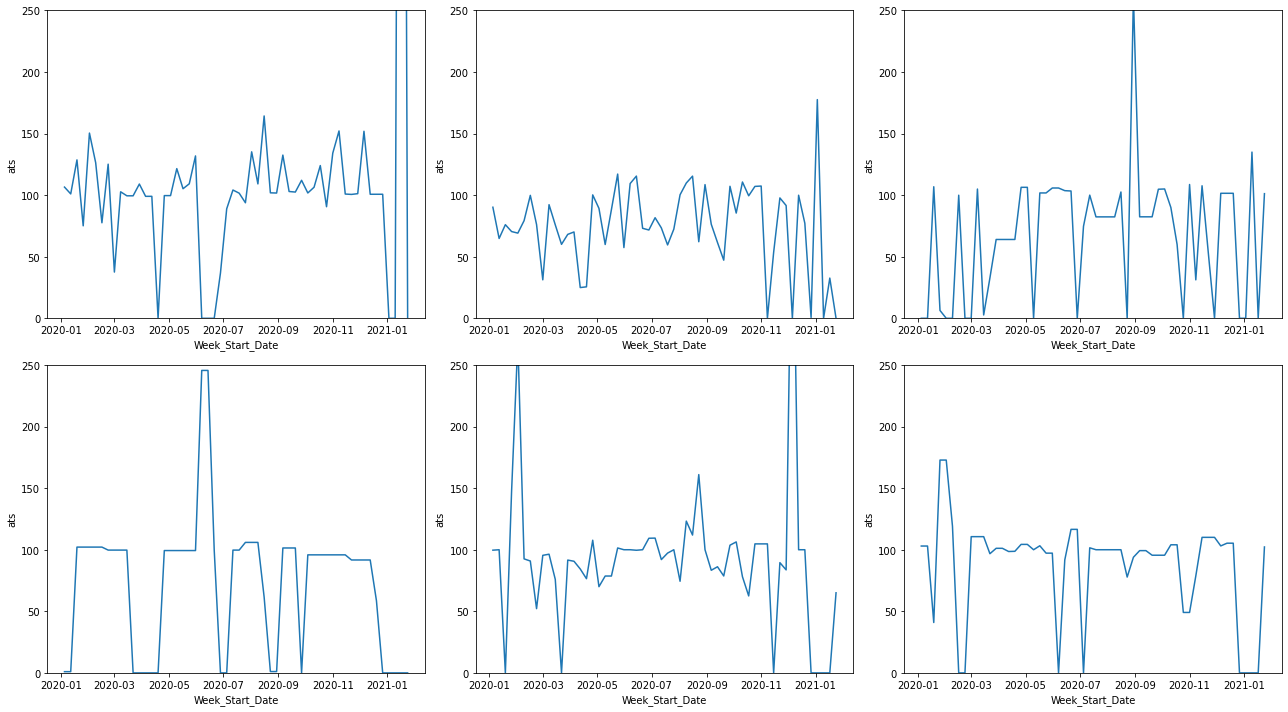

In [50]:
# Line chart ATS
prodn_grains = prodn_actuals_complete.groupby(['dfu','location'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#fig.suptitle('ATS trend over time for Different Grains')

i=0; j=0
for grain in num_of_data_pts_per_grain.index[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_grains.get_group(grain), x="Week_Start_Date", y="ats")
    ax.set(ylim=(0, 250))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    j+=1; 
    if j > 2:j=0;i=1

In [51]:
# Correlation Analysis
'''
To validate - CSL values
'''

ats_csl_corr_lag0 = prodn_actuals_complete.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats').reset_index().sort_values('P-Value')
ats_csl_corr_lag1 = prodn_actuals_complete.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats_lag1').reset_index().sort_values('P-Value')
ats_csl_corr_lag2 = prodn_actuals_complete.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats_lag2').reset_index().sort_values('P-Value')

#prodn_actuals_complete.to_csv(os.path.join(data_path,job_id,'exp','prodn_actuals_complete.csv'),index=False)
#ats_csl_corr_lag2.to_csv(os.path.join(data_path,job_id,'exp','ats_csl_corr_lag2.csv'),index=False)


In [52]:
# Examples where correlation is significant
lag2_significant = ats_csl_corr_lag2[ats_csl_corr_lag2['Correlation'] >= 0]
lag2_significant = lag2_significant[lag2_significant['P-Value']< 0.05]
print('Number of grains with signifiant correlations at lag2 - {}'.format(lag2_significant.shape[0]))

lag1_significant = ats_csl_corr_lag1[ats_csl_corr_lag1['Correlation'] >= 0]
lag1_significant = lag1_significant[lag1_significant['P-Value']< 0.05]
print('Number of grains with signifiant correlations at lag1 - {}'.format(lag1_significant.shape[0]))

lag0_significant = ats_csl_corr_lag0[ats_csl_corr_lag0['Correlation'] >= 0]
lag0_significant = lag0_significant[lag0_significant['P-Value']< 0.05]
print('Number of grains with signifiant correlations at lag0 - {}'.format(lag0_significant.shape[0]))


Number of grains with signifiant correlations at lag2 - 31
Number of grains with signifiant correlations at lag1 - 14
Number of grains with signifiant correlations at lag0 - 11


In [53]:
# When ATS is less than 100
prodn_temp = prodn_actuals_complete[prodn_actuals_complete['ats_lag2'] < 100]
ats_csl_corr_lag2_temp = prodn_temp.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats_lag2').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag2_temp[(ats_csl_corr_lag2_temp['P-Value']< 0.05) & (ats_csl_corr_lag2_temp['Correlation'] > 0)].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag2 - {}'.format(count))

prodn_temp = prodn_actuals_complete[prodn_actuals_complete['ats_lag1'] < 100]
ats_csl_corr_lag1_temp = prodn_temp.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats_lag1').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag1_temp[(ats_csl_corr_lag1_temp['P-Value']< 0.05) & (ats_csl_corr_lag1_temp['Correlation'] > 0)].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag1 - {}'.format(count))

prodn_temp = prodn_actuals_complete[prodn_actuals_complete['ats'] < 100]
ats_csl_corr_lag0_temp = prodn_temp.groupby(['dfu','location']).apply(get_ats_csl_correlation,'ats').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag0_temp[(ats_csl_corr_lag0_temp['P-Value']< 0.05) & (ats_csl_corr_lag0_temp['Correlation'] > 0)].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag0 - {}'.format(count))


Number of grains with signifiant correlations when ATS < 100 at lag2 - 34
Number of grains with signifiant correlations when ATS < 100 at lag1 - 22
Number of grains with signifiant correlations when ATS < 100 at lag0 - 20


### Line level correlation

In [54]:
# Prepare Line level Data
line_lvl_csl = pd.read_csv(os.path.join(data_path,job_id,'exp','csl_line_maping.csv'))
line_lvl_csl['Date'] = line_lvl_csl['Date'].apply(lambda x : datetime.strptime(x,'%d-%b-%y'))

prodn_actual_line = pd.read_csv(os.path.join(data_path,job_id,'input','production_actuals.csv'), dtype = {'dfu':str,'location':str})
prodn_actual_line['Week_Start_Date'] = prodn_actual_line['date'].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))
prodn_actual_line = prodn_actual_line[prodn_actual_line['Week_Start_Date'] >= datetime(2020, 1, 1)]

line_lvl_ats = prodn_actual_line.groupby(['line','Week_Start_Date']).agg(actual_production_in_ea = ('actual_production_in_ea','sum'),
                                                               scheduled_production_in_ea = ('scheduled_production_in_ea','sum')).reset_index()

line_data = line_lvl_ats.merge(line_lvl_csl,left_on = ['line','Week_Start_Date'], right_on = ['Production Line Item','Date'])

line_data = line_data.sort_values(by=['line','Week_Start_Date'])
line_data['ats'] = line_data.apply(recalculate_ats,axis=1)
line_data = line_data.groupby(['line']).apply(apply_ats_nan_per_group)

line_data['ats_lag1'] = line_data.groupby(['line'])['ats'].shift(1)
line_data['ats_lag2'] = line_data.groupby(['line'])['ats'].shift(2)
line_data['csl'] = line_data['Case Fillrate']

#line_data.to_csv(os.path.join(data_path,job_id,'exp','line_level_correlation_data.csv'),index=False)

In [55]:
line_corr_lag0 = line_data.groupby(['line']).apply(get_ats_csl_correlation,'ats').reset_index().sort_values('P-Value')
line_corr_lag1 = line_data.groupby(['line']).apply(get_ats_csl_correlation,'ats_lag1').reset_index().sort_values('P-Value')
line_corr_lag2 = line_data.groupby(['line']).apply(get_ats_csl_correlation,'ats_lag2').reset_index().sort_values('P-Value')

count = line_corr_lag2[(line_corr_lag2['Correlation']>0) & (line_corr_lag2['P-Value']<=0.05)].shape[0]
print('Number of grains with signifiant correlations at lag2 - {}'.format(count))

count = line_corr_lag1[(line_corr_lag1['Correlation']>0) & (line_corr_lag1['P-Value']<=0.05)].shape[0]
print('Number of grains with signifiant correlations at lag1 - {}'.format(count))

count = line_corr_lag0[(line_corr_lag0['Correlation']>0) & (line_corr_lag0['P-Value']<=0.05)].shape[0]
print('Number of grains with signifiant correlations at lag0 - {}'.format(count))

print(line_corr_lag2.shape)

Number of grains with signifiant correlations at lag2 - 4
Number of grains with signifiant correlations at lag1 - 7
Number of grains with signifiant correlations at lag0 - 6
(25, 6)


In [56]:
# When ATS is less than 100
prodn_temp = line_data[line_data['ats_lag2'] < 100]
ats_csl_corr_lag2_temp = prodn_temp.groupby(['line']).apply(get_ats_csl_correlation,'ats_lag2').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag2_temp[(ats_csl_corr_lag2_temp['P-Value']< 0.05) & (ats_csl_corr_lag2_temp['Correlation'] > 0)].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag2 - {}'.format(count))

prodn_temp = line_data[line_data['ats_lag1'] < 100]
ats_csl_corr_lag1_temp = prodn_temp.groupby(['line']).apply(get_ats_csl_correlation,'ats_lag1').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag1_temp[(ats_csl_corr_lag1_temp['P-Value']< 0.05) & (ats_csl_corr_lag1_temp['Correlation'] > 0)].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag1 - {}'.format(count))

prodn_temp = line_data[line_data['ats'] < 100]
ats_csl_corr_lag0_temp = prodn_temp.groupby(['line']).apply(get_ats_csl_correlation,'ats').reset_index().sort_values('P-Value')
count = ats_csl_corr_lag0_temp[(ats_csl_corr_lag0_temp['P-Value']< 0.05) & (ats_csl_corr_lag0_temp['Correlation'] > 0)].shape[0]
print('Number of grains with signifiant correlations when ATS < 100 at lag0 - {}'.format(count))


Number of grains with signifiant correlations when ATS < 100 at lag2 - 9
Number of grains with signifiant correlations when ATS < 100 at lag1 - 7
Number of grains with signifiant correlations when ATS < 100 at lag0 - 7


## DFU Level - ML Models

In [57]:
#0. Cap ATS and re-calculate scheduled quantity
prodn_actuals_complete['ats_capped'] = prodn_actuals_complete['ats'].apply(cap_ats)
prodn_actuals_complete['scheduled_production_in_ea'] = prodn_actuals_complete['actual_production_in_ea']*100/prodn_actuals_complete['ats_capped']
'''Column for accuracy metric => ats_capped'''


'Column for accuracy metric => ats_capped'

('104383', 'FR08')
('105230', 'NL01')
('106470', 'GB18')
('111010', 'PL01')
('130828', 'PL01')
('176429', 'PL01')


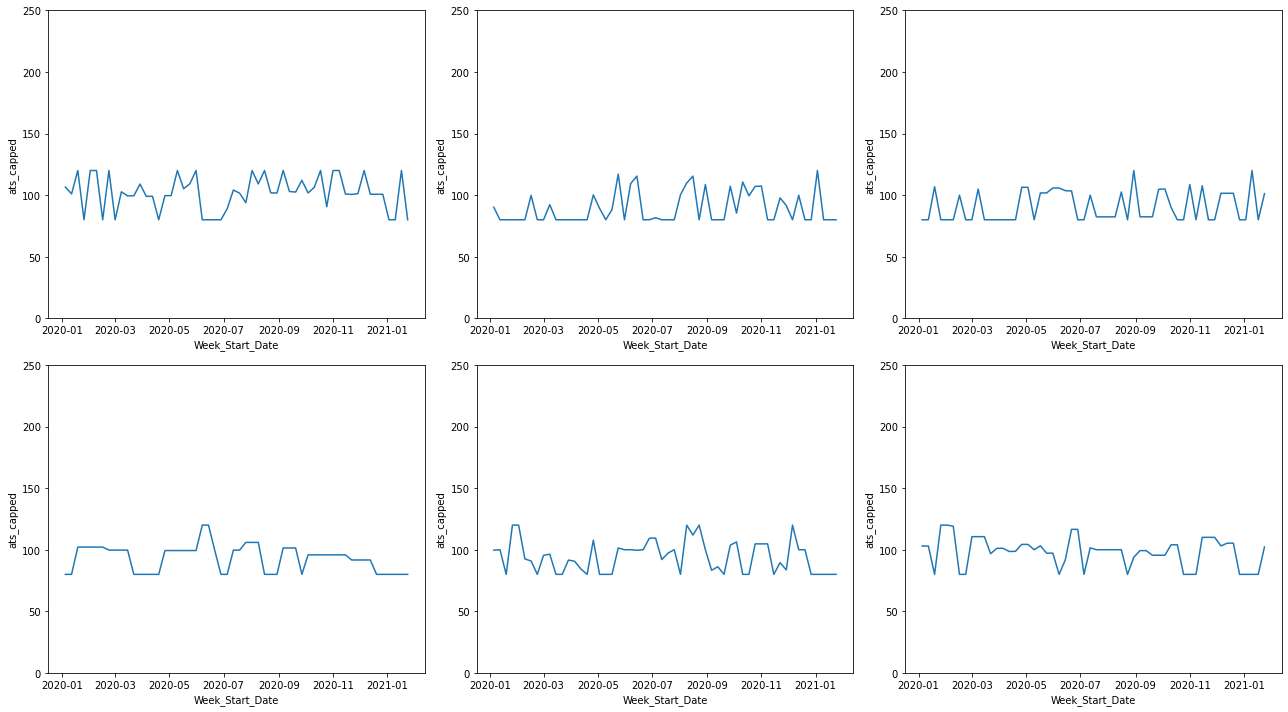

In [58]:
# Line chart ATS
prodn_grains = prodn_actuals_complete.groupby(['dfu','location'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#fig.suptitle('ATS trend over time for Different Grains')

i=0; j=0
for grain in num_of_data_pts_per_grain.index[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_grains.get_group(grain), x="Week_Start_Date", y="ats_capped")
    ax.set(ylim=(0, 250))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    j+=1; 
    if j > 2:j=0;i=1

In [59]:
## ML Pre-processing

#1. Most likely outcome
holdout_date = cortex_ip['Date'].iloc[0]
train = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] <= holdout_date]
test = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] > holdout_date]
print(test.shape)
accuracy_frame = test[['dfu','location','line','Week_Start_Date','scheduled_production_in_ea','ats_capped']]

train_mle = train[train['ffill_flag'] != 1]
test_mle = test[test['ffill_flag'] != 1]

most_likely_outcome = train_mle.groupby(['dfu','location']).agg(Most_Probable_Outcome = ('ats_capped',get_max_density_outcome)).reset_index()
accuracy_frame = accuracy_frame.merge(most_likely_outcome,on=['dfu','location'])

#2. Regression outcome
linregress_coeff = train.groupby(['dfu','location']).apply(train_linear_model,y='ats_capped',x='scheduled_production_in_ea').reset_index()
accuracy_frame = accuracy_frame.merge(linregress_coeff,on=['dfu','location'])
accuracy_frame['linregress_outcome'] = (accuracy_frame['slope']*accuracy_frame['scheduled_production_in_ea']) + accuracy_frame['intercept']

#3. Mars prediction of 100
accuracy_frame['mars_outcome'] = 100

accuracy_frame.head()

(897, 13)


dfu location        line Week_Start_Date  scheduled_production_in_ea  \
0  104383     FR08  HAG CRISPY      2020-12-06                      9617.5   
1  104383     FR08  HAG CRISPY      2020-12-13                     28271.0   
2  104383     FR08  HAG CRISPY      2020-12-20                     28271.0   
3  104383     FR08  HAG CRISPY      2020-12-27                     28271.0   
4  104383     FR08  HAG CRISPY      2021-01-03                     42262.5   

   ats_capped  Most_Probable_Outcome  level_2     slope  intercept  \
0  120.000000              119.81982        0  0.000167  99.939862   
1  100.710976              119.81982        0  0.000167  99.939862   
2  100.710976              119.81982        0  0.000167  99.939862   
3  100.710976              119.81982        0  0.000167  99.939862   
4   80.000000              119.81982        0  0.000167  99.939862   

   linregress_outcome  mars_outcome  
0          101.542316           100  
1          104.650334           100  
2          104.650334           100  
3          104.650334           100  
4          106.981577           100

('104383', 'FR08')
('105230', 'NL01')
('106470', 'GB18')
('111010', 'PL01')
('130828', 'PL01')
('176429', 'PL01')


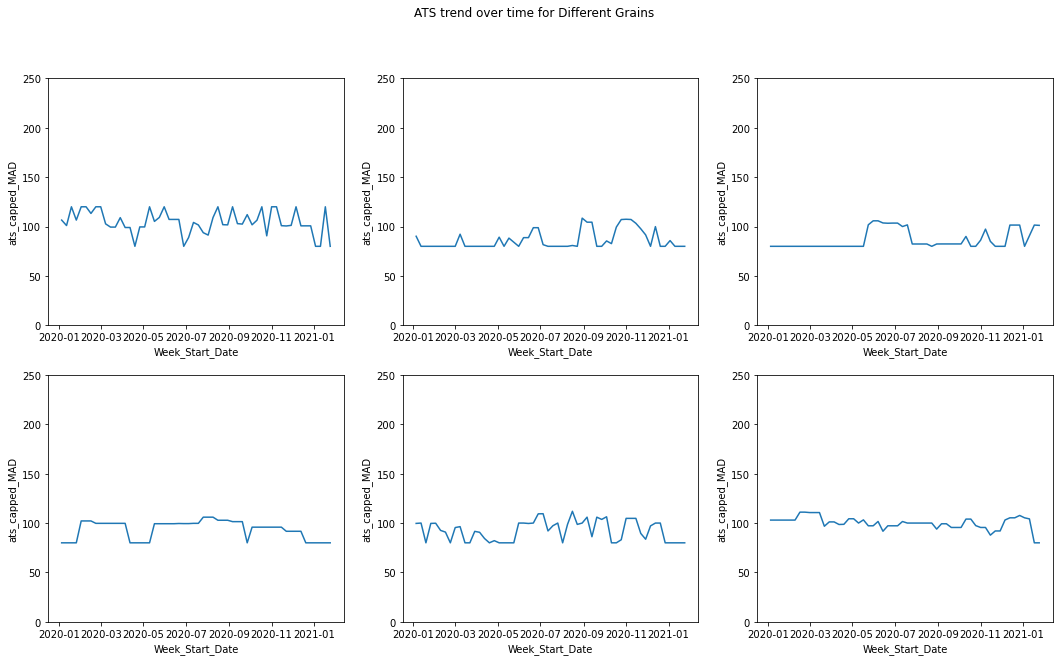

In [60]:
#4. Time series prediction

# Trend smoothening
prodn_actuals_complete = prodn_actuals_complete.groupby(['dfu','location']).apply(mad_outlier_treatment,'ats_capped').reset_index(drop=True)
prodn_actuals_complete = prodn_actuals_complete.groupby(['dfu','location']).apply(iqr_outlier_treatment,'ats_capped').reset_index(drop=True)

# Modified ATS time series
prodn_grains = prodn_actuals_complete.groupby(['dfu','location'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ATS trend over time for Different Grains')

i=0; j=0
for grain in num_of_data_pts_per_grain.index[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_grains.get_group(grain), x="Week_Start_Date", y="ats_capped_MAD")
    ax.set(ylim=(0, 250))
    j+=1; 
    if j > 2:j=0;i=1


In [61]:
def get_iso_yearweek(x):
    year = str(x.isocalendar()[0])
    week = str(x.isocalendar()[1])
    if len(week)==1:
        week = '0'+week
    return year+week

In [62]:
'''
x = prodn_actuals_complete[['Week_Start_Date','dfu','location','ats_capped_MAD']]
x['YearWeek'] = x['Week_Start_Date'].apply(lambda x: get_iso_yearweek(x))
x.columns = ['DD_STARTDATE','DD_DFU','DD_LOCATION','CT_SALES_HISTORY_EACHES','YearWeek']
y = x[['DD_STARTDATE','YearWeek']].drop_duplicates()
#x.to_csv(os.path.join(data_path,job_id,'exp','cortex_ip_ats_dfu_location_level.csv'),index=False)

#x['Week_Start_Date'][2].isocalendar()
'''

"\nx = prodn_actuals_complete[['Week_Start_Date','dfu','location','ats_capped_MAD']]\nx['YearWeek'] = x['Week_Start_Date'].apply(lambda x: get_iso_yearweek(x))\nx.columns = ['DD_STARTDATE','DD_DFU','DD_LOCATION','CT_SALES_HISTORY_EACHES','YearWeek']\ny = x[['DD_STARTDATE','YearWeek']].drop_duplicates()\n#x.to_csv(os.path.join(data_path,job_id,'exp','cortex_ip_ats_dfu_location_level.csv'),index=False)\n\n#x['Week_Start_Date'][2].isocalendar()\n"

In [63]:
'''# Cortex forecasting result
cortex_ats_fcst = pd.read_csv('/Users/sandeepdhankhar/OneDrive - Aera Technology/8 Project Mars/Data/02Feb2021/exp/cortex_ats_dfu_loc_forecast.csv')
cortex_ats_fcst = cortex_ats_fcst[['Grain-1','Grain-2','Actual Date Value','Ranking Mode Forecast Qty']]
cortex_ats_fcst = cortex_ats_fcst[cortex_ats_fcst['Actual Date Value'].isin([202049,202050,202051,202052,202053,202101,202102,202103])]
cortex_ats_fcst['Grain-1'] = cortex_ats_fcst['Grain-1'].astype(str)
cortex_ats_fcst['Actual Date Value'] = cortex_ats_fcst['Actual Date Value'].astype(str)
cortex_ats_fcst = cortex_ats_fcst.merge(y,left_on='Actual Date Value',right_on='YearWeek')

dfu_ts_predn = cortex_ats_fcst[['Grain-1','Grain-2','DD_STARTDATE','Ranking Mode Forecast Qty']]
dfu_ts_predn.columns = ['dfu','location','Week_Start_Date','Time_series_outcome']

accuracy_frame = accuracy_frame.merge(dfu_ts_predn,on=['dfu','location','Week_Start_Date'])
'''

# 6MA time series prediction
holdout_date = cortex_ip['Date'].iloc[0]
train = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] <= holdout_date]
test = prodn_actuals_complete[prodn_actuals_complete['Week_Start_Date'] > holdout_date]

futurePeriods =  pd.date_range(start = cortex_ip['Date'].iloc[0] + timedelta(days=7), 
                               end = cortex_ip['Date'].iloc[1], freq='W').to_list()
predn = []

for name,group in train.groupby(['dfu','location']):
    data = list(group['ats_capped_MAD'])
    # fit model
    model = ARIMA(data, order=(0, 0, 6))
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(len(data), len(data)+len(futurePeriods) - 1)

    predn.append(pd.DataFrame({'dfu':name[0],
                               'location':name[1],
                               'Week_Start_Date':futurePeriods,
                               'Time_series_outcome':yhat}))
    
dfu_ts_predn = pd.concat(predn).reset_index(drop=True)

accuracy_frame = accuracy_frame.merge(dfu_ts_predn,on=['dfu','location','Week_Start_Date'])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarnin

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximu

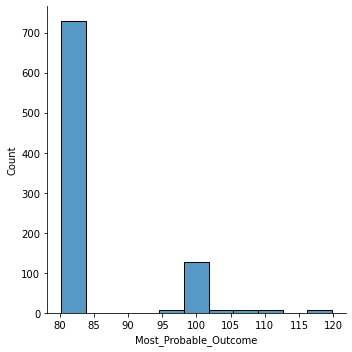

In [67]:
sns.displot(accuracy_frame, x="Most_Probable_Outcome")

<AxesSubplot:xlabel='Min_col', ylabel='count'>

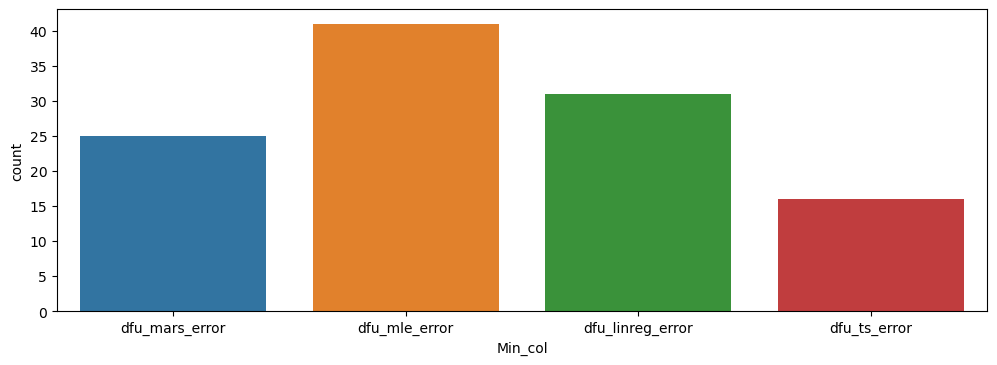

In [65]:
accuracy_frame_dfu = accuracy_frame.copy()

accuracy_frame_dfu['dfu_mle_error'] = abs(accuracy_frame_dfu['ats_capped'] - accuracy_frame_dfu['Most_Probable_Outcome'])
accuracy_frame_dfu['dfu_linreg_error'] = abs(accuracy_frame_dfu['ats_capped'] - accuracy_frame_dfu['linregress_outcome'])
accuracy_frame_dfu['dfu_mars_error'] = abs(accuracy_frame_dfu['ats_capped'] - accuracy_frame_dfu['mars_outcome'])
accuracy_frame_dfu['dfu_ts_error'] = abs(accuracy_frame_dfu['ats_capped'] - accuracy_frame_dfu['Time_series_outcome'])

best_method_selection = accuracy_frame_dfu.groupby(['dfu','location']).agg(dfu_mars_error = ('dfu_mars_error','mean'),
                                                                       dfu_mle_error = ('dfu_mle_error','mean'),
                                                                       dfu_linreg_error = ('dfu_linreg_error','mean'),
                                                                       dfu_ts_error = ('dfu_ts_error','mean'))

c = ['dfu_mars_error','dfu_ts_error','dfu_linreg_error','dfu_mle_error']
#c = ['dfu_mars_error','dfu_ts_error','dfu_linreg_error']
best_method_selection = best_method_selection[c]

best_method_selection.loc[:,c] = np.round(best_method_selection[c],2)
best_method_selection = best_method_selection.assign(Min_val = best_method_selection[c].min(axis=1), Min_col=best_method_selection[c].idxmin(axis=1))

fig=plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x="Min_col", data=best_method_selection)


In [66]:
best_method_selection['Min_col'].value_counts()
#best_method_selection.to_csv(os.path.join(data_path,job_id,'exp','dfu_ml_model_results.csv'))

dfu_mle_error       41
dfu_linreg_error    31
dfu_mars_error      25
dfu_ts_error        16
Name: Min_col, dtype: int64

## Line level - ATS models

In [56]:
'''
Line level correlation not possible to calculate (since CSL is not available at this level)
'''

'\nLine level correlation not possible to calculate (since CSL is not available at this level)\n'

BBN L1 MWCR
CHE Line2
HAG CHOCO
HAG CRISPY
HAG PEANUT
HAG_MIXUP


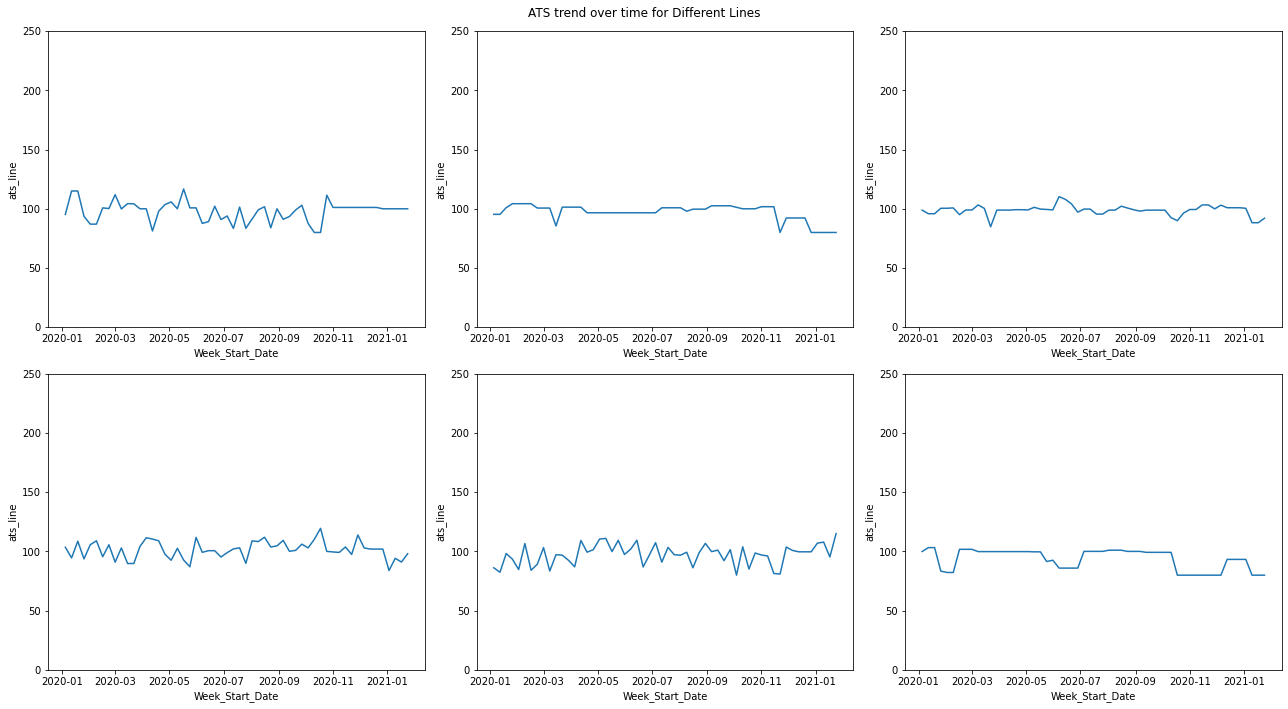

In [27]:
## Visualise the line level trend

line_level_prodn = prodn_actuals_complete.groupby(['line','Week_Start_Date']).agg(actual_production_in_ea = ('actual_production_in_ea','sum'),
                                                              scheduled_production_in_ea = ('scheduled_production_in_ea','sum')).reset_index()
line_level_prodn['ats_line'] = line_level_prodn.apply(recalculate_ats,axis=1)

# Line chart ATS
prodn_line = line_level_prodn.groupby(['line'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ATS trend over time for Different Lines')

i=0; j=0
for grain in line_level_prodn.line.unique()[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_line.get_group(grain), x="Week_Start_Date", y="ats_line")
    ax.set(ylim=(0, 250))
    plt.tight_layout()
    j+=1; 
    if j > 2:j=0;i=1


In [28]:
#1. Most likely outcome
holdout_date = cortex_ip['Date'].iloc[0]
train = line_level_prodn[line_level_prodn['Week_Start_Date'] <= holdout_date]
test = line_level_prodn[line_level_prodn['Week_Start_Date'] > holdout_date]
print(test.shape)
accuracy_frame_line = test[['line','Week_Start_Date','scheduled_production_in_ea','ats_line']]
most_likely_outcome = train.groupby(['line']).agg(Most_Probable_Outcome = ('ats_line',get_max_density_outcome)).reset_index()
accuracy_frame_line = accuracy_frame_line.merge(most_likely_outcome,on=['line'])

#2. Regression outcome
linregress_coeff = train.groupby(['line']).apply(train_linear_model,y='ats_line',x='scheduled_production_in_ea').reset_index()
accuracy_frame_line = accuracy_frame_line.merge(linregress_coeff,on=['line'])
accuracy_frame_line['linregress_outcome'] = (accuracy_frame_line['slope']*accuracy_frame_line['scheduled_production_in_ea']) + accuracy_frame_line['intercept']

accuracy_frame_line.head()

(200, 5)


line Week_Start_Date  scheduled_production_in_ea    ats_line  \
0  BBN L1 MWCR      2020-12-06                     70378.0  101.146665   
1  BBN L1 MWCR      2020-12-13                     70378.0  101.146665   
2  BBN L1 MWCR      2020-12-20                     70378.0  101.146665   
3  BBN L1 MWCR      2020-12-27                         0.0  100.000000   
4  BBN L1 MWCR      2021-01-03                         0.0  100.000000   

   Most_Probable_Outcome  level_1    slope  intercept  linregress_outcome  
0             100.600601        0 -0.00004  98.634766           95.844967  
1             100.600601        0 -0.00004  98.634766           95.844967  
2             100.600601        0 -0.00004  98.634766           95.844967  
3             100.600601        0 -0.00004  98.634766           98.634766  
4             100.600601        0 -0.00004  98.634766           98.634766

BBN L1 MWCR
CHE Line2
HAG CHOCO
HAG CRISPY
HAG PEANUT
HAG_MIXUP


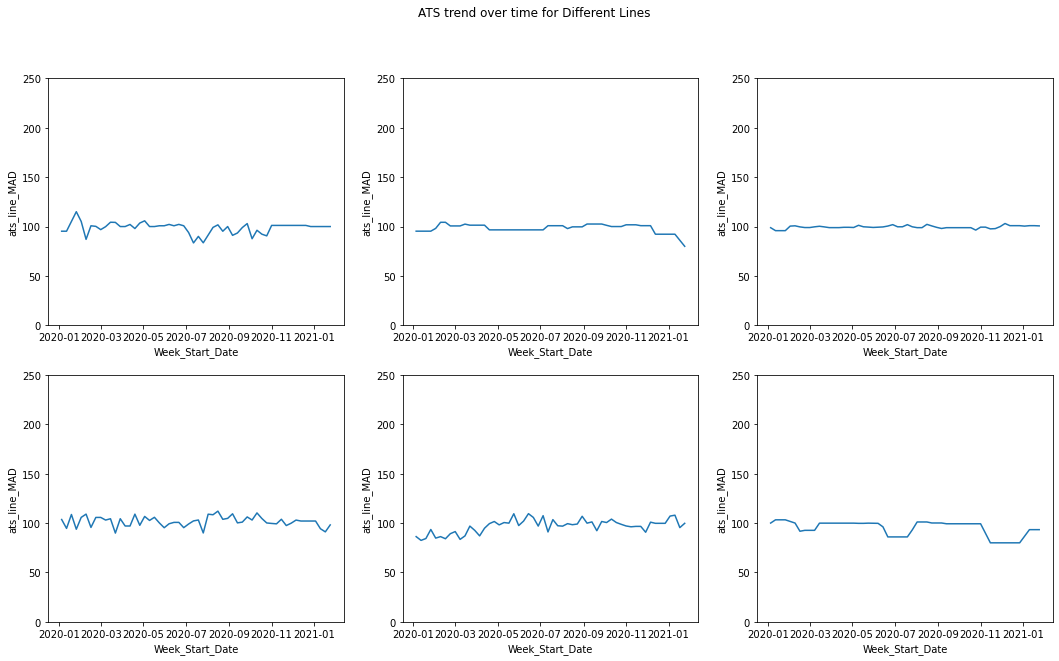

In [29]:
# Trend smoothening
line_level_prodn = line_level_prodn.groupby(['line']).apply(mad_outlier_treatment,'ats_line').reset_index(drop=True)
line_level_prodn = line_level_prodn.groupby(['line']).apply(iqr_outlier_treatment,'ats_line').reset_index(drop=True)

# Line chart ATS
prodn_line = line_level_prodn.groupby(['line'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ATS trend over time for Different Lines')

i=0; j=0
for grain in line_level_prodn.line.unique()[0:6]:
    print(grain)
    ax = sns.lineplot(ax = axes[i,j],data=prodn_line.get_group(grain), x="Week_Start_Date", y="ats_line_MAD")
    ax.set(ylim=(0, 250))
    j+=1; 
    if j > 2:j=0;i=1


In [30]:
#3. Time series prediction

# 6MA time series prediction
holdout_date = cortex_ip['Date'].iloc[0]
train = line_level_prodn[line_level_prodn['Week_Start_Date'] <= holdout_date]
test = line_level_prodn[line_level_prodn['Week_Start_Date'] > holdout_date]

futurePeriods =  pd.date_range(start = cortex_ip['Date'].iloc[0] + timedelta(days=7), 
                               end = cortex_ip['Date'].iloc[1], freq='W').to_list()
predn = []

for name,group in train.groupby(['line']):
    data = list(group['ats_line_MAD'])
    # fit model
    model = ARIMA(data, order=(0, 0, 6))
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(len(data), len(data)+len(futurePeriods) - 1)

    predn.append(pd.DataFrame({'line':name,
                               'Week_Start_Date':futurePeriods,
                               'Time_series_outcome':yhat}))
    
line_ts_predn = pd.concat(predn).reset_index(drop=True)

accuracy_frame_line = accuracy_frame_line.merge(line_ts_predn,on=['line','Week_Start_Date'])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarnin

In [31]:
accuracy_frame_line = accuracy_frame_line[['line','Week_Start_Date','Most_Probable_Outcome','linregress_outcome','Time_series_outcome']]
accuracy_frame_line.columns = ['line','Week_Start_Date','Most_Probable_Outcome_line','linregress_outcome_line','Time_series_outcome_line']
accuracy_frame_line.head()

line Week_Start_Date  Most_Probable_Outcome_line  \
0  BBN L1 MWCR      2020-12-06                  100.600601   
1  BBN L1 MWCR      2020-12-13                  100.600601   
2  BBN L1 MWCR      2020-12-20                  100.600601   
3  BBN L1 MWCR      2020-12-27                  100.600601   
4  BBN L1 MWCR      2021-01-03                  100.600601   

   linregress_outcome_line  Time_series_outcome_line  
0                95.844967                102.222378  
1                95.844967                 98.779110  
2                95.844967                 97.575064  
3                98.634766                101.058362  
4                98.634766                 95.623094

In [32]:
accuracy_frame = accuracy_frame.merge(accuracy_frame_line,on=['line','Week_Start_Date'])

<ipython-input-33-9e22613190ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_frame_line_tmp['dfu_mars_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['mars_outcome'])
<ipython-input-33-9e22613190ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_frame_line_tmp['line_mle_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['Most_Probable_Outcome_line'])
<ipython-input-33-9e22613190ce>:5: SettingWithCopyWarning: 
A value is trying 

<AxesSubplot:xlabel='Min_col', ylabel='count'>

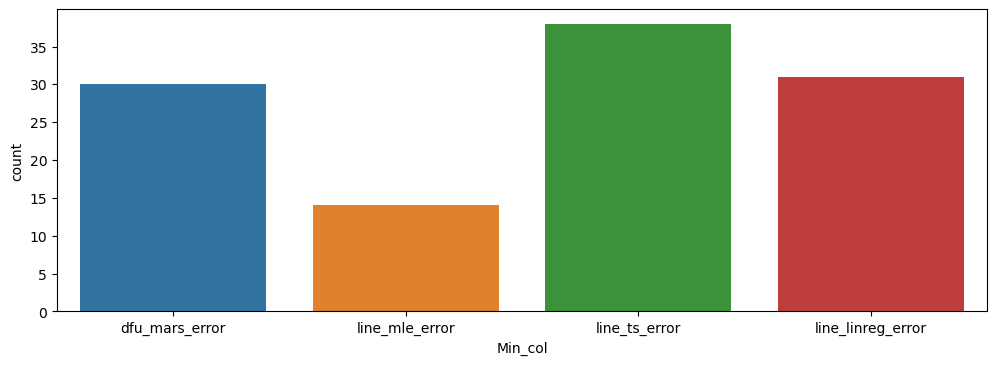

In [33]:
accuracy_frame_line_tmp = accuracy_frame[['dfu','location','line','Week_Start_Date','ats_capped','mars_outcome','Most_Probable_Outcome_line','linregress_outcome_line','Time_series_outcome_line']]

accuracy_frame_line_tmp['dfu_mars_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['mars_outcome'])
accuracy_frame_line_tmp['line_mle_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['Most_Probable_Outcome_line'])
accuracy_frame_line_tmp['line_linreg_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['linregress_outcome_line'])
accuracy_frame_line_tmp['line_ts_error'] = abs(accuracy_frame_line_tmp['ats_capped'] - accuracy_frame_line_tmp['Time_series_outcome_line'])

best_method_selection = accuracy_frame_line_tmp.groupby(['dfu','location']).agg(dfu_mars_error = ('dfu_mars_error','mean'),                                                                       
                                                                       line_mle_error = ('line_mle_error','mean'),
                                                                       line_linreg_error = ('line_linreg_error','mean'),
                                                                       line_ts_error = ('line_ts_error','mean'))

c = ['dfu_mars_error','line_mle_error','line_linreg_error','line_ts_error']
best_method_selection = best_method_selection[c]

best_method_selection.loc[:,c] = np.round(best_method_selection[c],2)
best_method_selection = best_method_selection.assign(Min_val = best_method_selection[c].min(axis=1), Min_col=best_method_selection[c].idxmin(axis=1))

fig=plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x="Min_col", data=best_method_selection)


In [34]:
best_method_selection.Min_col.value_counts()

line_ts_error        38
line_linreg_error    31
dfu_mars_error       30
line_mle_error       14
Name: Min_col, dtype: int64

In [35]:
#best_method_selection.to_csv(os.path.join(data_path,job_id,'exp','line_ml_model_results.csv'))

## Compare all the methods

In [ ]:
accuracy_frame.head()

In [ ]:
accuracy_frame['dfu_mle_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['Most_Probable_Outcome'])
accuracy_frame['dfu_linreg_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['linregress_outcome'])
accuracy_frame['dfu_mars_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['mars_outcome'])
accuracy_frame['dfu_ts_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['Time_series_outcome'])

accuracy_frame['line_mle_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['Most_Probable_Outcome_line'])
accuracy_frame['line_linreg_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['linregress_outcome_line'])
accuracy_frame['line_ts_error'] = abs(accuracy_frame['ats_capped'] - accuracy_frame['Time_series_outcome_line'])


best_method_selection = accuracy_frame.groupby(['dfu','location']).agg(dfu_mars_error = ('dfu_mars_error','mean'),
                                                                       dfu_mle_error = ('dfu_mle_error','mean'),
                                                                       dfu_linreg_error = ('dfu_linreg_error','mean'),
                                                                       dfu_ts_error = ('dfu_ts_error','mean'),
                                                                       line_mle_error = ('line_mle_error','mean'),
                                                                       line_linreg_error = ('line_linreg_error','mean'),
                                                                       line_ts_error = ('line_ts_error','mean'))

c = ['line_mle_error','line_linreg_error','line_ts_error','dfu_ts_error','dfu_linreg_error','dfu_mle_error','dfu_mars_error']
best_method_selection = best_method_selection[c]

best_method_selection.loc[:,c] = np.round(best_method_selection[c],2)
best_method_selection = best_method_selection.assign(Min_val = best_method_selection[c].min(axis=1), Min_col=best_method_selection[c].idxmin(axis=1))

fig=plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
sns.countplot(x="Min_col", data=best_method_selection)
